# Sat Chirp Backgrounder
By Terry Bondy, VA3TYB

In [31]:
printf(strftime ("Last updated: %A %e %B %Y", localtime (time ())))

Last updated: Monday 21 October 2019

# Scope
What is described here is background for a means of determining the 
instantaneous translating properties of a linear satellite by sending 
a single brief 'chirp' in the uplink and listening across the satellite band 
for the downlink with an SDR and doing some processing. These translation 
properties include:
* The instantaneous tranlation frequency,
* Whether the downlink is USB or LSB.

# Producing This Document
This document is produced using [Octave](https://www.gnu.org/software/octave/), an open source tool very similar to
*Matlab*. The lines in the boxes are *Octave* commands to create the 
mathematical examples that are used. Octave is being run in a [Jupyter](https://jupyterlab.readthedocs.io/en/stable/) notebook which can be access from the internet, TBD.

But first a bit of bookkeeping.


In [ ]:
%plot --format svg

# Strategy for Determining Downlink Frequency of the Uplink Chirp
To further describe the strategy for determining the downlink frequency
of the uplink chirp, the SDR will receive the complete satellite downlink
band and do processing on it. It will look at the _frequency_ representation
of the chirp that is decided on and determine its frequency offset.

In order to determine the frequency offset, the process will use a 
[matched filter](https://en.wikipedia.org/wiki/Matched_filter). An example
of a matched filter will demonstrate the two properties that will make it 
useful for this process:
* It is easy to determine whether the signal originating the matched filter is present,
* It is easy to determine when the signal originating the matched filter has completed.

For this example we wish to detect a 20 Hz cosine pulse 1s long.

In [ ]:
sample_rate = 6000; # Sampling at 6 kHz
T_base = [0: 1/sample_rate: 1]; # The time base, sampling at 6 kHz
V_cos_pulse = cos(2*pi*20*T_base);

plot(T_base, V_cos_pulse)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 1: Cosine Pulse - Time domain")
axis([-0.5 1.5 -2 2])

As it turns out the matched filter is the time reversed version of the
signal, which in this case is the signal itself because $cos(2\pi*20*t) = cos(2\pi*20*-t)$

The output of the filter is determined by convolving the input signal
with the matched filter.

For the first part of the example, the input
is the signal itself followed by 4 sec of silence, then the signal again, then 4 sec of silence, then the signal and then lastly 4 sec of silence.

In [ ]:
V_4s_silence = zeros(1, sample_rate*4);
V_input = horzcat(V_cos_pulse, V_4s_silence, V_cos_pulse, V_4s_silence, V_cos_pulse, V_4s_silence);
T_base = [0: 1/sample_rate: (size(V_input,2)-1)/sample_rate]; # The time base
plot(T_base, V_input)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 2: Input Signal - Time Domain")
axis([-0.5 15.5 -2 2])

To do the matching, we convolve the time reversed signal we are searching for with the input signal. The peaks of the output indicate the moment of times the signal was detected.

In [ ]:
V_matching = flip(V_cos_pulse); # 'flip' does the time reversing, not really necessary for this signal
V_matched = conv(V_matching, V_input);
T_base = [0: 1/sample_rate: (size(V_matched,2)-1)/sample_rate]; # The time base, sampling at 6 kHz
plot(T_base, V_matched)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 3: Matched Filter Output - Time Domain")
axis([-0.5 15.5])

The peaks of the envelope determines where each of the cosine pulses end.

For the next part of the example, it will be determined if the signal
can be detected in the presence of noise. First come up with
the input signal with the noise at a SNR = -20.

In [ ]:
snr = -20; # dB
# Linearize the SNR
snr_lin = 10^(snr/10);
# Determine the original signal power
e_sig = sum(abs(V_cos_pulse).^2)/size(V_cos_pulse,2);
# And then get noise spectral density
n_0 = e_sig/snr_lin;
n_sigma = sqrt(n_0);

V_noise = n_sigma * randn(1,size(V_input,2));
V_noisy_input = V_input .+ V_noise;
T_base = [0: 1/sample_rate: (size(V_input,2)-1)/sample_rate]; # The time base
plot(T_base, V_noisy_input)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 4: Input Signal with Noise - Time Domain")
axis([-0.5 15.5])

Can you see the pulse amongst the noise? Let's plot them next to each other
for magnitude comparision (Figure 5).

In [ ]:
V_compare = horzcat(V_input, V_noise);
T_base = [0: 1/sample_rate: (size(V_compare,2)-1)/sample_rate]; # The time base
plot(T_base, V_compare)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 5: Magnitude Comparision of Cosine Pulses and Noise - Time Domain")
axis([-0.5 30.5])

Finally lets examine the matched filter output (Figure 6).

In [ ]:
V_matched = conv(V_matching, V_noisy_input);
T_base = [0: 1/sample_rate: (size(V_matched,2)-1)/sample_rate]; # The time base, sampling at 6 kHz
plot(T_base, V_matched)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 6: Matched Filter Output - Time Domain")
axis([-0.5 15.5])

So even though the cosine pulses are 20 dB less than the noise, the matched filter
is able to pull them out.

# A Brief Review of Signal Analysis In The Time and Frequency Domains 
Before taking on using a matched filter in the _frequency_ domain, a short review of signal analysis in both the time and frequency domain.

Consider again a 20 Hz cosine pulse lasting 1s (Figure 1).

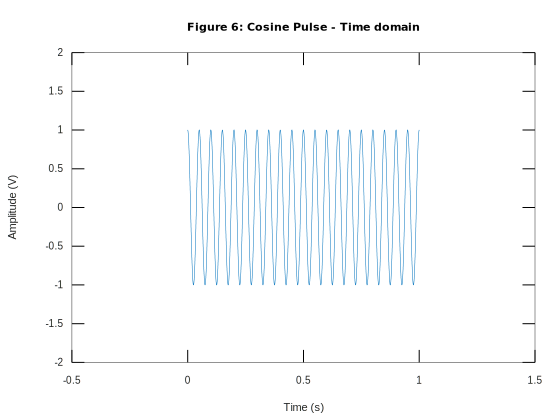

In [32]:
T_base = [0: 1/sample_rate: 1]; # The time base, sampling at 6 kHz
V_cos_pulse = cos(2*pi*20*T_base);

plot(T_base, V_cos_pulse)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 6: Cosine Pulse - Time domain")
axis([-0.5 1.5 -2 2])

Now we use a fast-fourier-transform (FFT) to determine the frequency components of the signal (Figure 6).

Use `fft` to do an analysis of the time signal in the 
frequency domain. Use `fftshift` to shift 0 Hz to the 
centre of the vector.

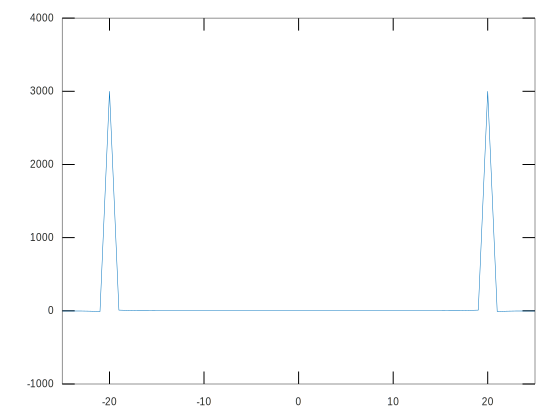

In [38]:
V_of_f = fftshift(fft(V_cos_pulse));
F_base = [-sample_rate/2: 1: sample_rate/2];
plot(F_base, V_of_f)
axis([-25 25])

The energy at +/- 20 Hz can be seen, although the resolution is lacking. To increase the resolution, the time sample can be extended. If the resolution was only 1 Hz when the sample was only 1s long, it will be 0.1 Hz when the sample is 10s long.

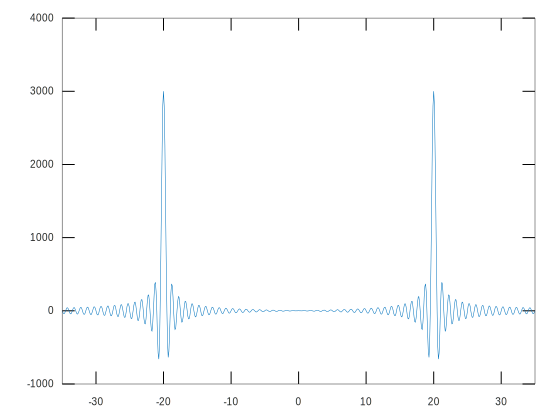

In [45]:
V_9s_silence = zeros(1, sample_rate*9);
V_of_f = fftshift(fft(horzcat(V_cos_pulse, V_9s_silence)));
F_base = [-sample_rate/2: 1/10: sample_rate/2];
plot(F_base, V_of_f)
axis([-35 35])

Create a vector of frequencies for plotting

In [ ]:
F = [-24000: 1/10: 24000];

...and then plot the voltage in the frequency domain

In [ ]:
plot(F, V_of_f)
ylabel("Amplitude (V)");
xlabel("Frequency (Hz)");
title("Figure 2: Modulating Triangular Pulse - Frequency domain")
axis([-25 25 -1.01 1.01])

It can be seen from the graph that the primary components consist of
frequencies at and around +20 Hz and -20 Hz.

Note that real value signals
will have +ve and -ve frequency components.

The same process can be used
with complex phasors by using `exp(i*2*pi*20*T)` or `exp(-i*2*pi*20*T)` in 
place of `cos(2*pi*20*T)`. For the +ve phasor the time signal looks the 
same (Figure 3).

Create a vector of voltages for those times

In [ ]:
V_of_t = 2 * exp(i*2*pi*20*T) .* (0.5 - abs(T));

In [ ]:
plot(T, V_of_t)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 3: Modulating Triangular Pulse (exp(i*2*pi*20*T)) - Time domain")
axis('square')
axis([-0.51 0.51 -1.01 1.01])

The FFT is calculated again (Figure 4).

In [ ]:
V_of_f = fftshift(fft(V_of_t, (size(V_of_t,2)-1)*10+1)/(size(V_of_t,2)/2));

In [ ]:
plot(F, V_of_f)
ylabel("Amplitude (V)");
xlabel("Frequency (Hz)");
title("Figure 4: Modulating Triangular Pulse (exp(i*2*pi*20*T)) - Frequency domain")
axis('square')
axis([-25 25 -1.01 1.01])

Looking at the FFT there is only one sideband, the USB. Also, the
component has twice the energy of the previos two, representing conservation
of energy.

Now for `exp(-i*2*pi*20*T)` (Figure 5). 

Create a vector of voltages for those times

In [ ]:
V_of_t = 2 * exp(-i*2*pi*20*T) .* (0.5 - abs(T));

In [ ]:
plot(T, V_of_t)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 5: Modulating Triangular Pulse (exp(-i*2*pi*20*T)) - Time domain")
axis('square')
axis([-0.51 0.51 -1.01 1.01])

The FFT is calculated (Figure 6).

In [ ]:
V_of_f = fftshift(fft(V_of_t, (size(V_of_t,2)-1)*10+1)/(size(V_of_t,2)/2));

In [ ]:
F = [-24000: 1/10: 24000];

In [ ]:
plot(F, V_of_f)
ylabel("Amplitude (V)");
xlabel("Frequency (Hz)");
title("Figure 6: Modulating Triangular Pulse (exp(-i*2*pi*20*T)) - Frequency domain")
axis('square')
axis([-25 25 -1.01 1.01])

Looking at the FFT there is only one sideband, the LSB.

So far in the examples a matched filter is shown working in the time domain.
Matched filters can also be used in the frequency domain. In this case it
is possible to determine the frequency offset of the signal. The process
is the following:
* RF pulse -> FFT -> flip in frequency = matched filter
* input signal -> FFT -> convolve with matched filter = matched filter output

There is a property in time/frequency analysis that can be brought to bear,
specifically convolution of two signals in one domain is multiplication in
the other. So now the process becomes:
* RF pulse -> FFT -> flip in frequency -> reverse FFT -> matched filter in time domain
* input signal -> multiply by matched filter in time domain -> FFT = matched filter output

For the example we are going to use the 20 Hz RF pulse, but just the USB.
Examine first the matched filter in the time domain (Figure 11).

In [ ]:
T = [0: 1/48000: 1];
V_of_t = exp(2*i*pi*20*T);
V_input = horzcat(V_of_t, zeros(1, 48000*4));
MatchedFilter_of_t = ifft(flip(fft(V_input)));
plot([0: 1/48000: (size(MatchedFilter_of_t,2)-1)/48000], MatchedFilter_of_t)
ylabel("Amplitude (V)")
xlabel("Time (s)")
title("Figure 11: Matched Filter - Time Domain")
axis('square')

In [ ]:
snr = -20; # dB
# Linearize the SNR
snr_lin = 10^(snr/10);
# Determine the original signal power
e_sig = sum(abs(V_of_t).^2)/size(V_of_t,2);
# And then get noise spectral density
n_0 = e_sig/snr_lin;
n_sigma = sqrt(n_0);

V_noise = n_sigma * randn(1,size(V_input,2));

V_signal = V_input .+ V_noise; # Use the same noise from the other example
V_signal_2 = V_signal .* MatchedFilter_of_t;
V_of_f = fft(V_signal_2)/(size(V_signal_2,2)/2);
F = [0: 1/5: (size(V_signal,2)-1)/5]; # 5 comes from length of sample in time
plot(F, V_of_f)
ylabel("Amplitude (V)");
xlabel("Frequency (Hz)");
title("Figure 12: Modulating Triangular Pulse (exp(-i*2*pi*20*T)) - Frequency domain")

In [ ]:
So now lets use the same pulse, but shift its frequency to 120 Hz and
add some noise, multiply by the matched filter, then look at a plot of the
FFT.

In [ ]:
V_of_t = exp(2*i*pi*120*T);
V_input = horzcat(V_of_t, zeros(1, 48000*4));


snr = -20; # dB
# Linearize the SNR
snr_lin = 10^(snr/10);
# Determine the original signal power
e_sig = sum(abs(V_of_t).^2)/size(V_of_t,2);
# And then get noise spectral density
n_0 = e_sig/snr_lin;
n_sigma = sqrt(n_0);

V_noise = n_sigma * randn(1,size(V_input,2));
V_signal = V_input .+ V_noise; # Use the same noise from the other example
V_signal_2 = V_signal .* MatchedFilter_of_t;
V_of_f = fft(V_signal_2)/(size(V_signal_2,2)/2);

In [ ]:
F = [0: 1/5: (size(V_signal_2,2)-1)/5]; # 5 comes from length of sample in time

In [ ]:
plot(F, V_of_f)
ylabel("Amplitude (V)");
xlabel("Frequency (Hz)");
title("Figure 12: Modulating Triangular Pulse (exp(-i*2*pi*20*T)) - Frequency domain")
axis('square')